# Task 4: Develop a hand gesture regonition model that can acurately identify and classify different hand gestures from images or video data

## Importing the necessary libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import random

## 2. Load and Preprocess Gesture Images

In [2]:
def load_gesture_images(data_dir, img_size):
    images = []
    labels = []
    label_names = set()

    # First pass: Collect unique gesture labels
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if not os.path.isdir(person_path):
            continue
        for gesture in os.listdir(person_path):
            gesture_path = os.path.join(person_path, gesture)
            if os.path.isdir(gesture_path):
                label_names.add(gesture)

    # Mapping gestures to numeric labels
    label_map = {name: idx for idx, name in enumerate(sorted(label_names))}
    print("Label Mapping:", label_map)

    # Second pass: Load and resize images
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if not os.path.isdir(person_path):
            continue
        for gesture in os.listdir(person_path):
            gesture_path = os.path.join(person_path, gesture)
            if not os.path.isdir(gesture_path):
                continue
            label = label_map[gesture]
            for img_file in os.listdir(gesture_path):
                file_path = os.path.join(gesture_path, img_file)
                if file_path.lower().endswith((".png", ".jpg", ".jpeg")):
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img)
                    labels.append(label)

    images = np.array(images).reshape(-1, img_size, img_size, 1) / 255.0
    labels = to_categorical(labels)

    print(f"Total Images Loaded: {len(images)}")
    print(f"Total Classes: {len(label_map)}")
    
    return images, labels, label_map

## 3. Define the CNN Model for Gesture Recognition

In [3]:
def build_gesture_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 4. Plot Training and Validation Accuracy

In [4]:
def plot_training_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

## 5. Evaluate Model and Show Confusion Matrix

In [5]:
def evaluate_model(model, x_test, y_test, class_names):
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

## 6. Visualize Predictions with Actual vs Predicted labels

In [6]:
def visualize_predictions(x_data, y_data, predictions, class_names, num_samples=10):
    indices = random.sample(range(len(x_data)), num_samples)
    fig, axes = plt.subplots(num_samples // 2, 2, figsize=(10, num_samples * 2))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        img = x_data[idx]
        true_label = np.argmax(y_data[idx])
        predicted_label = np.argmax(predictions[idx])

        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Actual: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}")

    plt.tight_layout()
    plt.show()

## 7. Main Execution Flow

In [7]:
# ==== MAIN EXECUTION BLOCK ====
if __name__ == "__main__":
    # Path to your main dataset folder
    data_dir = "leapGestRecog"
    IMG_SIZE = 64
    
    # Step 1: Load data
    x, y, label_map = load_gesture_images(data_dir, img_size=IMG_SIZE)
    class_names = list(label_map.keys())
    
    # Step 2: Split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Step 3: Build model
    model = build_gesture_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=len(class_names))

    # Step 4: Train model
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=10, batch_size=32,
                        validation_data=(x_test, y_test), callbacks=[early_stop])

Label Mapping: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}
Total Images Loaded: 20000
Total Classes: 10
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 115ms/step - accuracy: 0.6850 - loss: 1.0505 - val_accuracy: 0.6108 - val_loss: 1.3265
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step - accuracy: 0.9782 - loss: 0.0617 - val_accuracy: 0.9990 - val_loss: 0.0025
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step - accuracy: 0.9864 - loss: 0.0403 - val_accuracy: 0.9912 - val_loss: 0.0321
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9885 - loss: 0.0392 - val_accuracy: 0.9995 - val_loss: 9.8460e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9951 - loss: 0.0164 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9905 - loss: 0.0397 - val_accuracy: 0.9992 - val_loss: 0.0027
Epo

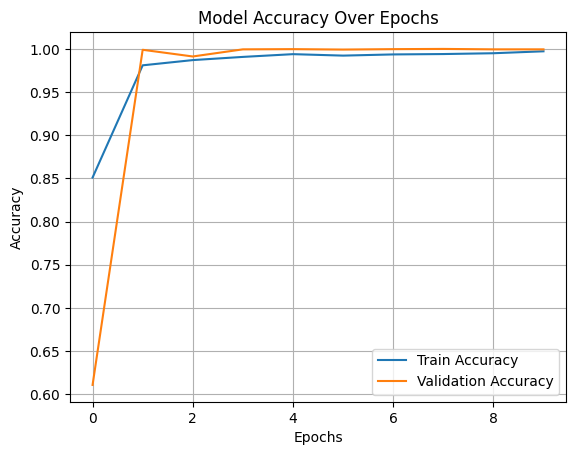

In [8]:
# Step 5: Plot training history
plot_training_accuracy(history)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       417
         02_l       1.00      1.00      1.00       404
      03_fist       1.00      1.00      1.00       404
04_fist_moved       1.00      1.00      1.00       418
     05_thumb       1.00      1.00      1.00       377
     06_index       1.00      1.00      1.00       392
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       409
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       366

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



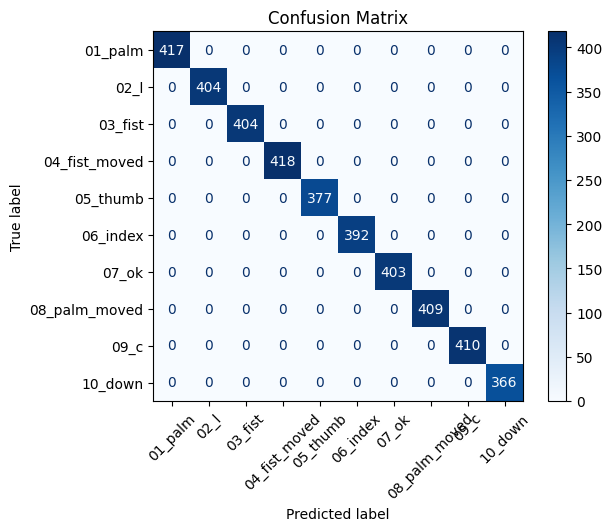

Model saved as 'gesture_cnn_model.h5


In [9]:
# Step 6: Evaluate and save model
evaluate_model(model, x_test, y_test, class_names)
model.save("gesture_cnn_model.h5")
print("Model saved as 'gesture_cnn_model.h5")

In [10]:
# Step 7: Reload model and make predictions
model = load_model('gesture_cnn_model.h5')
model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


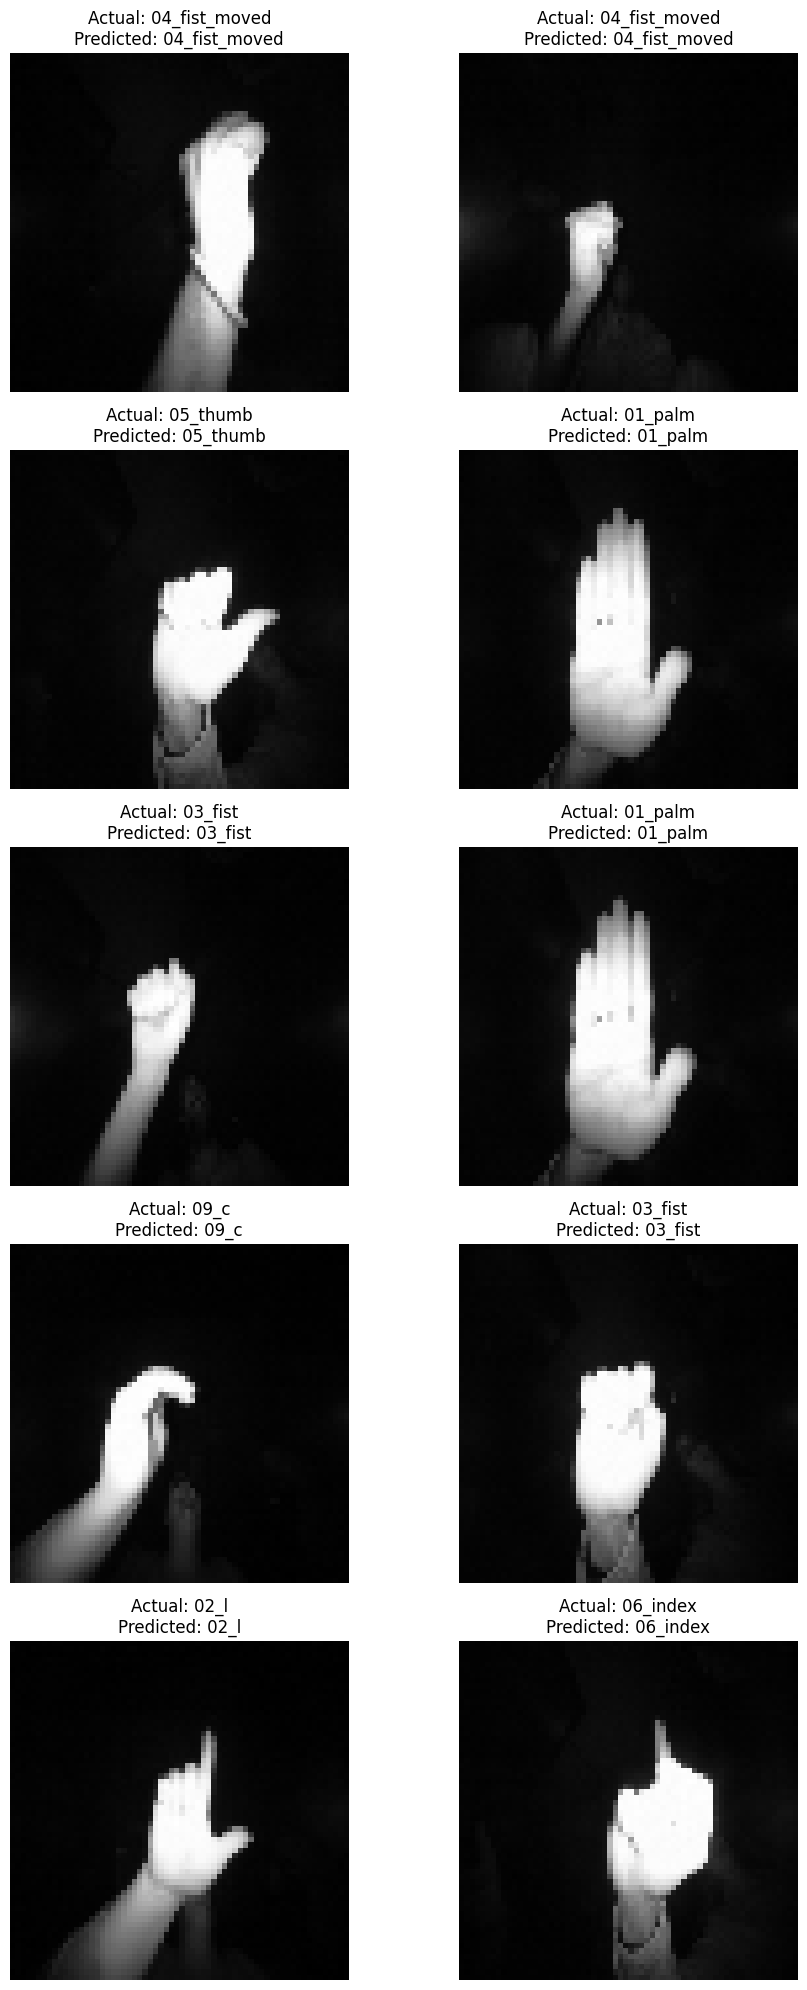

In [11]:
# Step 8: Visualize predictions
visualize_predictions(x_test, y_test, predictions, class_names, num_samples=10)